# Project notebook

The following notebook is an excerpt and re-written example from a _real_ production model.

The overall purpose of the ML algorithm is to identify users on the website that are new possible customers. This is done by collecting behaviour data from the users as input, and the target is whether they converted/turned into customers -- essentially a classification problem. 

This notebook only focuses on the data processing part. As you know, there are multiple steps in an ML pipeline, and it's not always they are neatly separated like this. For the exam project, they will not be, and that is part of the challenge for you. For production code, it should also not be Python notebooks since, as you may well see, it is difficult to work with and collaborate on them in an automated way.

There is a lot of "fluff" in such a notebook. This ranges from comments and markdown cells to commented out code and random print statements. That is not necessary in a properly managed project where you can use git to check the version history and such. 

What is important for you is the identify the entry points into the code and segment them out into easily understandable chunks. Additionally, you might want to follow some basic code standards, such as:

- Import only libraries in the beginning of the files
- Define functions in the top of the scripts, or if used multiple places, move into a util.py script or such
- Remove unused/commented out code
- Follow the [PEP 8](https://peps.python.org/pep-0008/) style guide (and others)
  
Another thing to note is that comments can be misleading. Even if the markdown cell or inline comments says it does _X_, don't be surprised if it actually does _Y_. Sometimes additional text can be a blessing, but it can also be a curse sometimes. Remember, though, that your task is to make sure the code runs as before after refactoring the notebook into other files, not update/improve the model or flow to reflect what the comments might say.

***

# DATA PROCESSING

In this section, we will perform Exploratory Data Analysis (EDA) to better understand the dataset before proceeding with more advanced analysis. EDA helps us get a sense of the data’s structure, identify patterns, and spot any potential issues like missing values or outliers. By doing so, we can gain a clearer understanding of the data's key characteristics.

We will start with summary statistics to review basic measures like mean, median, and variance, providing an initial overview of the data distribution. Then, we’ll create visualizations such as histograms, box plots, and scatter plots to explore relationships between variables, check for any skewness, and highlight outliers.

The purpose of this EDA is to ensure that the dataset is clean and well-structured for further analysis. This step also helps us identify any necessary data transformations and informs decisions on which features might be most relevant for modeling in later stages.

# Create artifact directory
We want to create a directory for storing all the artifacts in the current directory. Users can load all the artifacts later for data cleaning pipelines and inferencing.

In [7]:
# dbutils.widgets.text("Training data max date", "2024-01-31")
# dbutils.widgets.text("Training data min date", "2024-01-01")
# max_date = dbutils.widgets.get("Training data max date")
# min_date = dbutils.widgets.get("Training data min date")

# testnng
max_date = "2024-01-31"
min_date = "2024-01-01"

In [8]:
import os
import shutil
from pprint import pprint

# shutil.rmtree("./artifacts",ignore_errors=True)
os.makedirs("artifacts",exist_ok=True)
print("Created artifacts directory")

Created artifacts directory


# Pandas dataframe print options

In [9]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.float_format',lambda x: "%.3f" % x)

# Helper functions

* **describe_numeric_col**: Calculates various descriptive stats for a numeric column in a dataframe.
* **impute_missing_values**: Imputes the mean/median for numeric columns or the mode for other types.

In [10]:
def describe_numeric_col(x):
    """
    Parameters:
        x (pd.Series): Pandas col to describe.
    Output:
        y (pd.Series): Pandas series with descriptive stats. 
    """
    return pd.Series(
        [x.count(), x.isnull().count(), x.mean(), x.min(), x.max()],
        index=["Count", "Missing", "Mean", "Min", "Max"]
    )

def impute_missing_values(x, method="mean"):
    """
    Parameters:
        x (pd.Series): Pandas col to describe.
        method (str): Values: "mean", "median"
    """
    if (x.dtype == "float64") | (x.dtype == "int64"):
        x = x.fillna(x.mean()) if method=="mean" else x.fillna(x.median())
    else:
        x = x.fillna(x.mode()[0])
    return x

# Read data

We read the latest data from our data lake source. Here we load it locally after having pulled it from DVC.

In [11]:
!dvc pull

Fetching
!
  0% Checking cache in '/Users/alexjizdan/projectitu/itu-sdse-project/notebooks/
                                                                                
!
  0% Checking cache in 'https://github.com/Jeppe-T-K/itu-sdse-project-data/files
md5: 05663184eaf8f324162e4d1bc14be387
Fetching
Building workspace index                             |2.00 [00:00, 1.01kentry/s]
Comparing indexes                                    |3.00 [00:00, 2.69kentry/s]
Applying changes                                      |0.00 [00:00,     ?file/s]
Everything is up to date.


In [13]:
print("Loading training data")

data = pd.read_csv("raw_data.csv")

print("Total rows:", data.count())
display(data.head(5))


Loading training data
Total rows: lead_id                              12345
lead_indicator                       11753
date_part                            12345
is_active                            12345
marketing_consent                    12345
first_booking                        12345
existing_customer                    12345
last_seen                            12345
source                               12345
domain                               12345
country                              12345
visited_learn_more_before_booking    12345
visited_faq                          12345
purchases                            12345
time_spent                           12345
customer_group                       12345
onboarding                           12345
customer_code                        12294
n_visits                             12345
dtype: int64


,lead_id,lead_indicator,date_part,is_active,marketing_consent,first_booking,existing_customer,last_seen,source,domain,country,visited_learn_more_before_booking,visited_faq,purchases,time_spent,customer_group,onboarding,customer_code,n_visits
0,0,0.000,2024-01-24,0,True,2024-01-25,False,2024-01-13,organic,.dk,US,8,10,5,115.064,2,True,NaN,9
1,1,NaN,2024-01-1,1,True,2024-01-24,False,2024-01-6,signup,.dk,US,0,3,5,119.907,2,False,AGMVEYWACO,1
2,2,1.000,2024-01-27,0,True,2024-01-30,True,2024-01-30,signup,.dk,DK,7,10,3,100.474,5,False,STWPXVNOWA,16
3,3,1.000,2024-01-28,0,False,2024-01-10,False,2024-01-11,li,.cn,US,10,10,4,98.572,4,True,HZOKZERLZD,16
4,4,0.000,2024-01-5,0,True,2024-01-30,True,2024-01-25,fb,.com,US,5,1,5,101.996,9,False,CVLIHCAPZN,2


In [14]:
import pandas as pd
import datetime
import json

if not max_date:
    max_date = pd.to_datetime(datetime.datetime.now().date()).date()
else:
    max_date = pd.to_datetime(max_date).date()

min_date = pd.to_datetime(min_date).date()

# Time limit data
data["date_part"] = pd.to_datetime(data["date_part"]).dt.date
data = data[(data["date_part"] >= min_date) & (data["date_part"] <= max_date)]

min_date = data["date_part"].min()
max_date = data["date_part"].max()
date_limits = {"min_date": str(min_date), "max_date": str(max_date)}
with open("./artifacts/date_limits.json", "w") as f:
    json.dump(date_limits, f)

In [15]:
data.head()

,lead_id,lead_indicator,date_part,is_active,marketing_consent,first_booking,existing_customer,last_seen,source,domain,country,visited_learn_more_before_booking,visited_faq,purchases,time_spent,customer_group,onboarding,customer_code,n_visits
0,0,0.000,2024-01-24,0,True,2024-01-25,False,2024-01-13,organic,.dk,US,8,10,5,115.064,2,True,NaN,9
1,1,NaN,2024-01-01,1,True,2024-01-24,False,2024-01-6,signup,.dk,US,0,3,5,119.907,2,False,AGMVEYWACO,1
2,2,1.000,2024-01-27,0,True,2024-01-30,True,2024-01-30,signup,.dk,DK,7,10,3,100.474,5,False,STWPXVNOWA,16
3,3,1.000,2024-01-28,0,False,2024-01-10,False,2024-01-11,li,.cn,US,10,10,4,98.572,4,True,HZOKZERLZD,16
4,4,0.000,2024-01-05,0,True,2024-01-30,True,2024-01-25,fb,.com,US,5,1,5,101.996,9,False,CVLIHCAPZN,2


In [17]:
data.shape

(12345, 19)

In [18]:
data.describe()

# Missing values
missing = data.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(data)) * 100
pd.concat([missing, missing_percent], axis=1, keys=['Missing Count', 'Missing %'])

,Missing Count,Missing %
lead_indicator,592,4.795
customer_code,51,0.413
lead_id,0,0.000
country,0,0.000
onboarding,0,0.000
customer_group,0,0.000
time_spent,0,0.000
purchases,0,0.000
visited_faq,0,0.000
visited_learn_more_before_booking,0,0.000


In [19]:
data.duplicated().sum()


np.int64(0)

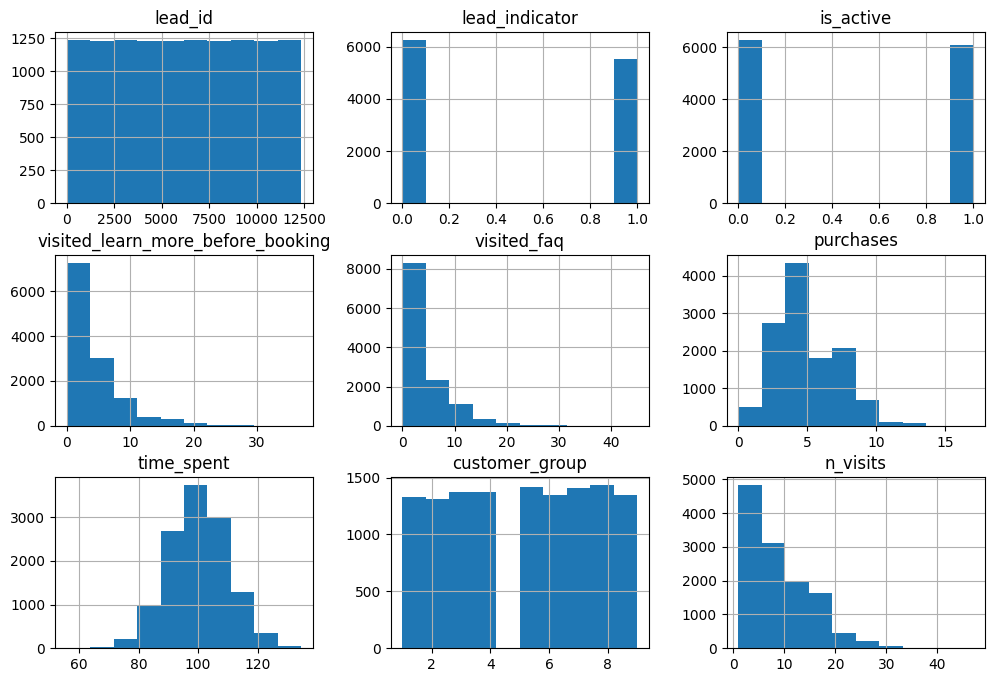

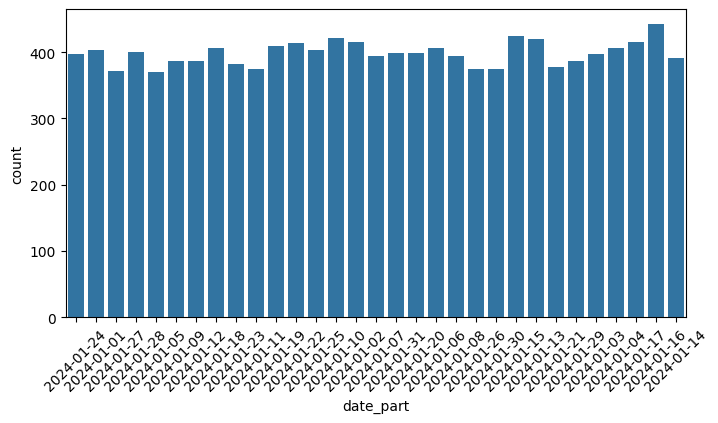

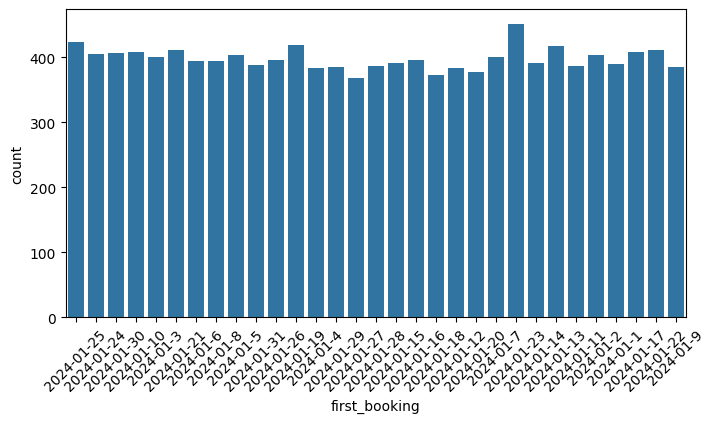

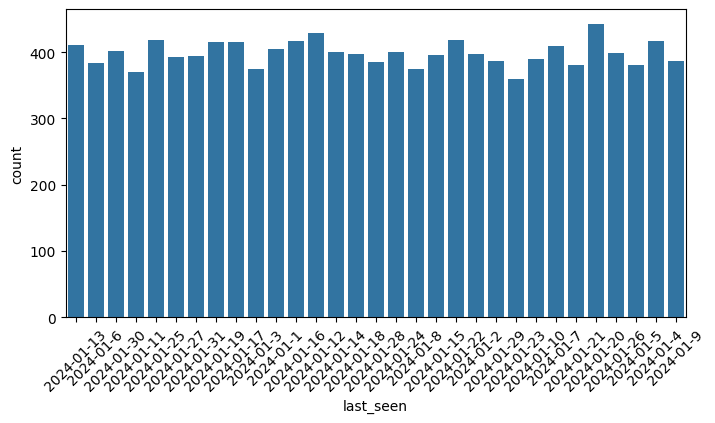

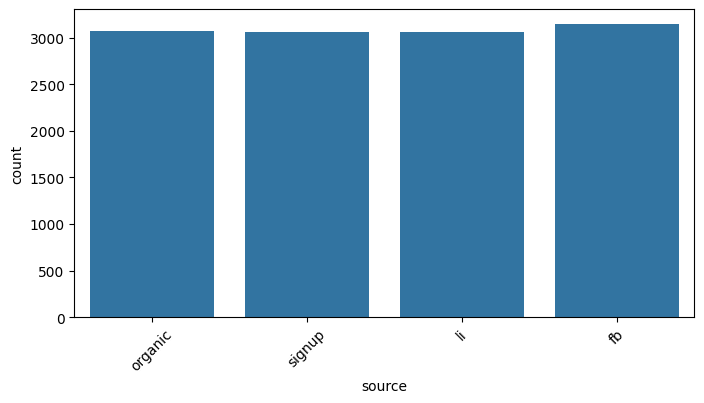

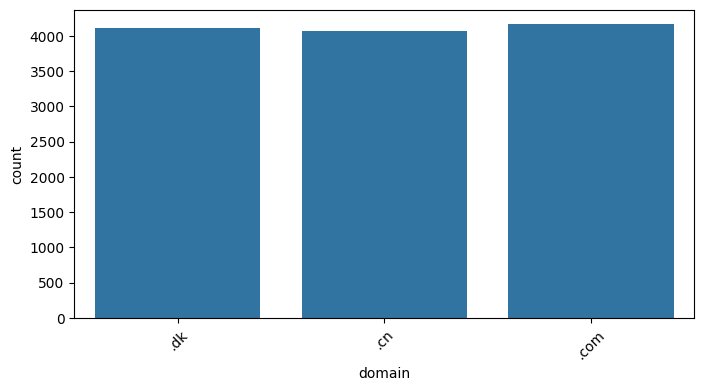

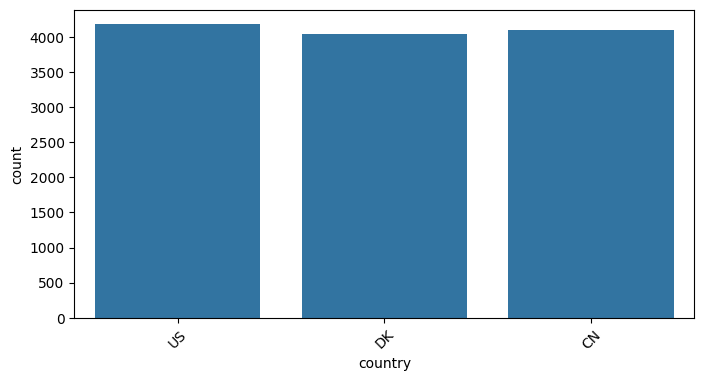

KeyboardInterrupt: 

In [23]:
import matplotlib.pyplot as plt

data.hist(figsize=(12,8))
plt.show()

import seaborn as sns

for col in data.select_dtypes(include='object').columns:
    plt.figure(figsize=(8,4))
    sns.countplot(data=data, x=col)
    plt.xticks(rotation=45)
    plt.show()


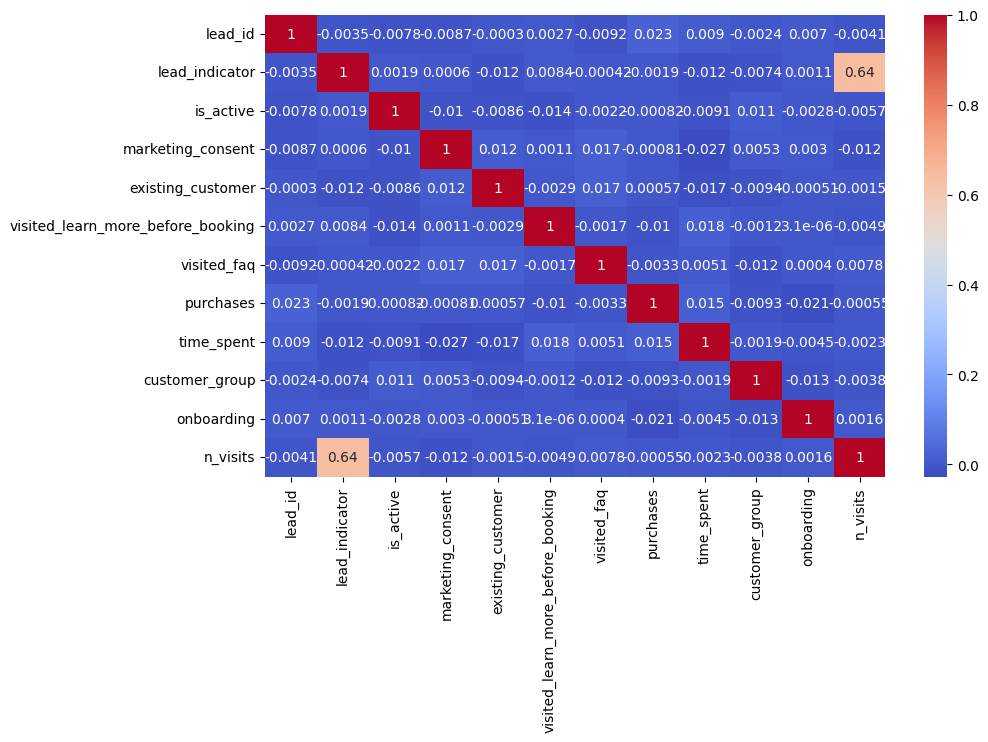

ValueError: Could not interpret value `target` for `x`. An entry with this name does not appear in `data`.

In [24]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

# Example: relationship between target and predictors
sns.boxplot(data=data, x='target', y='some_numeric_column')
plt.show()


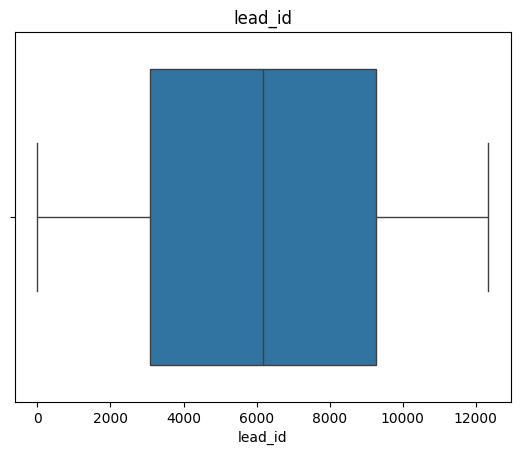

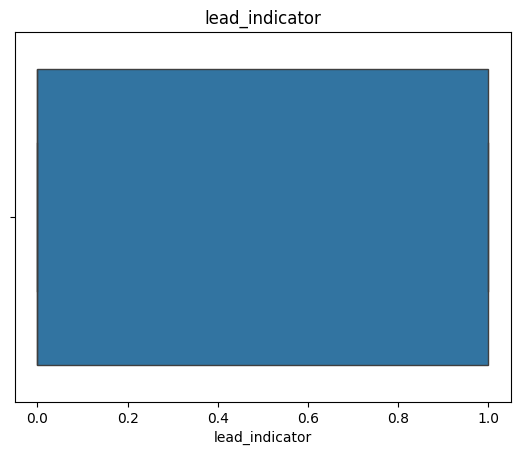

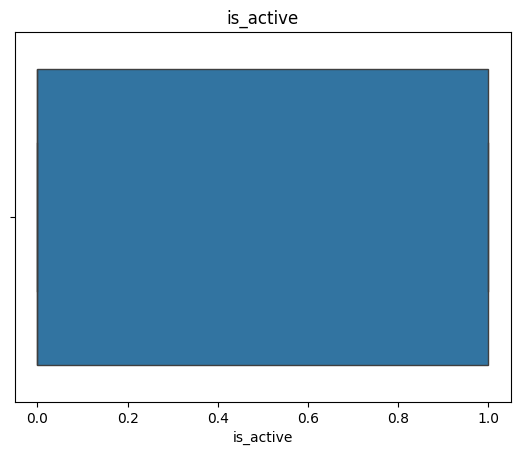

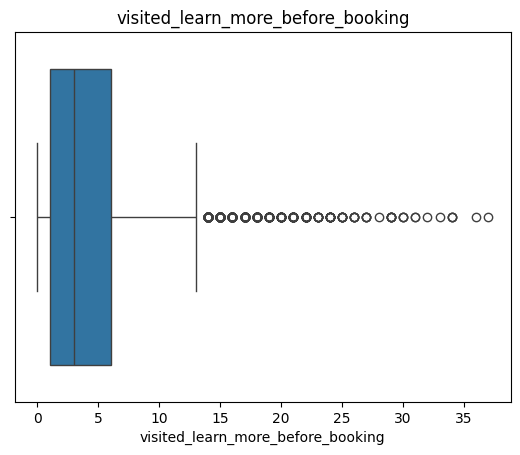

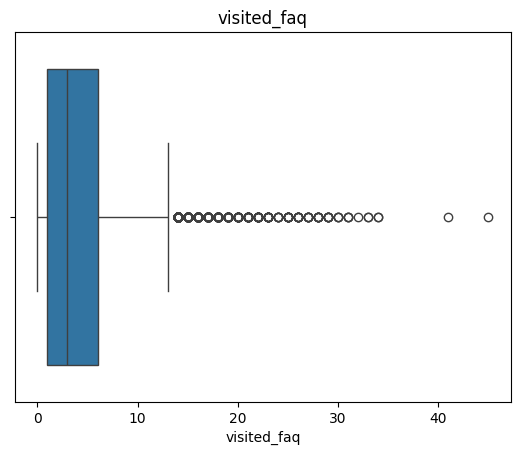

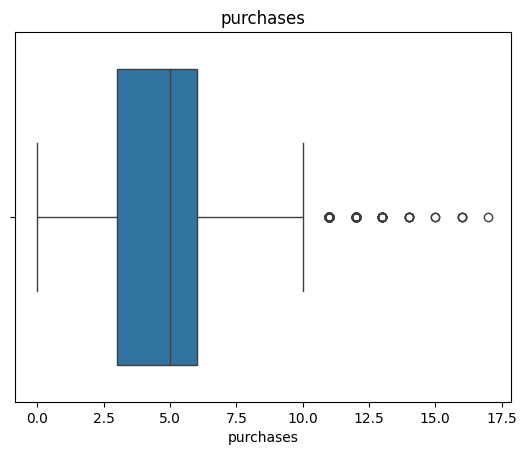

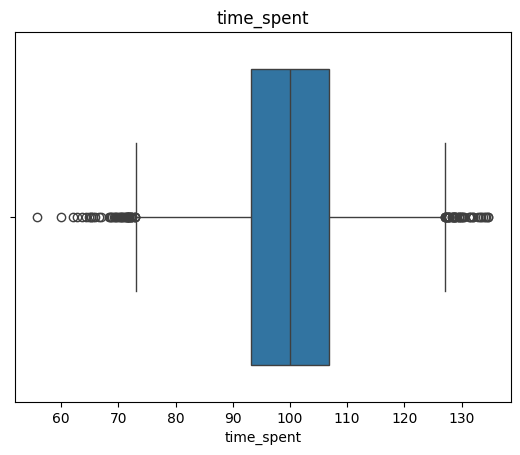

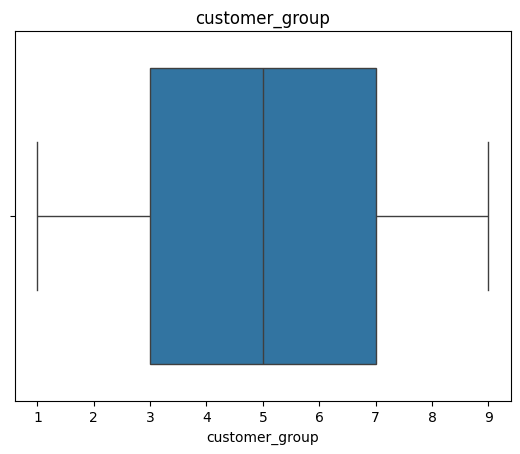

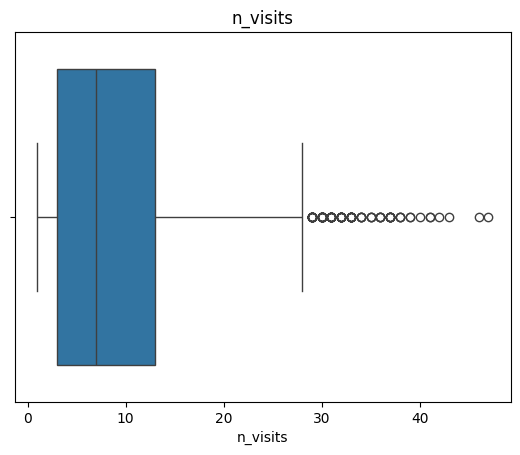

In [27]:
# Using boxplots
for col in data.select_dtypes(include='number').columns:
    sns.boxplot(x=data[col])
    plt.title(col)
    plt.show()


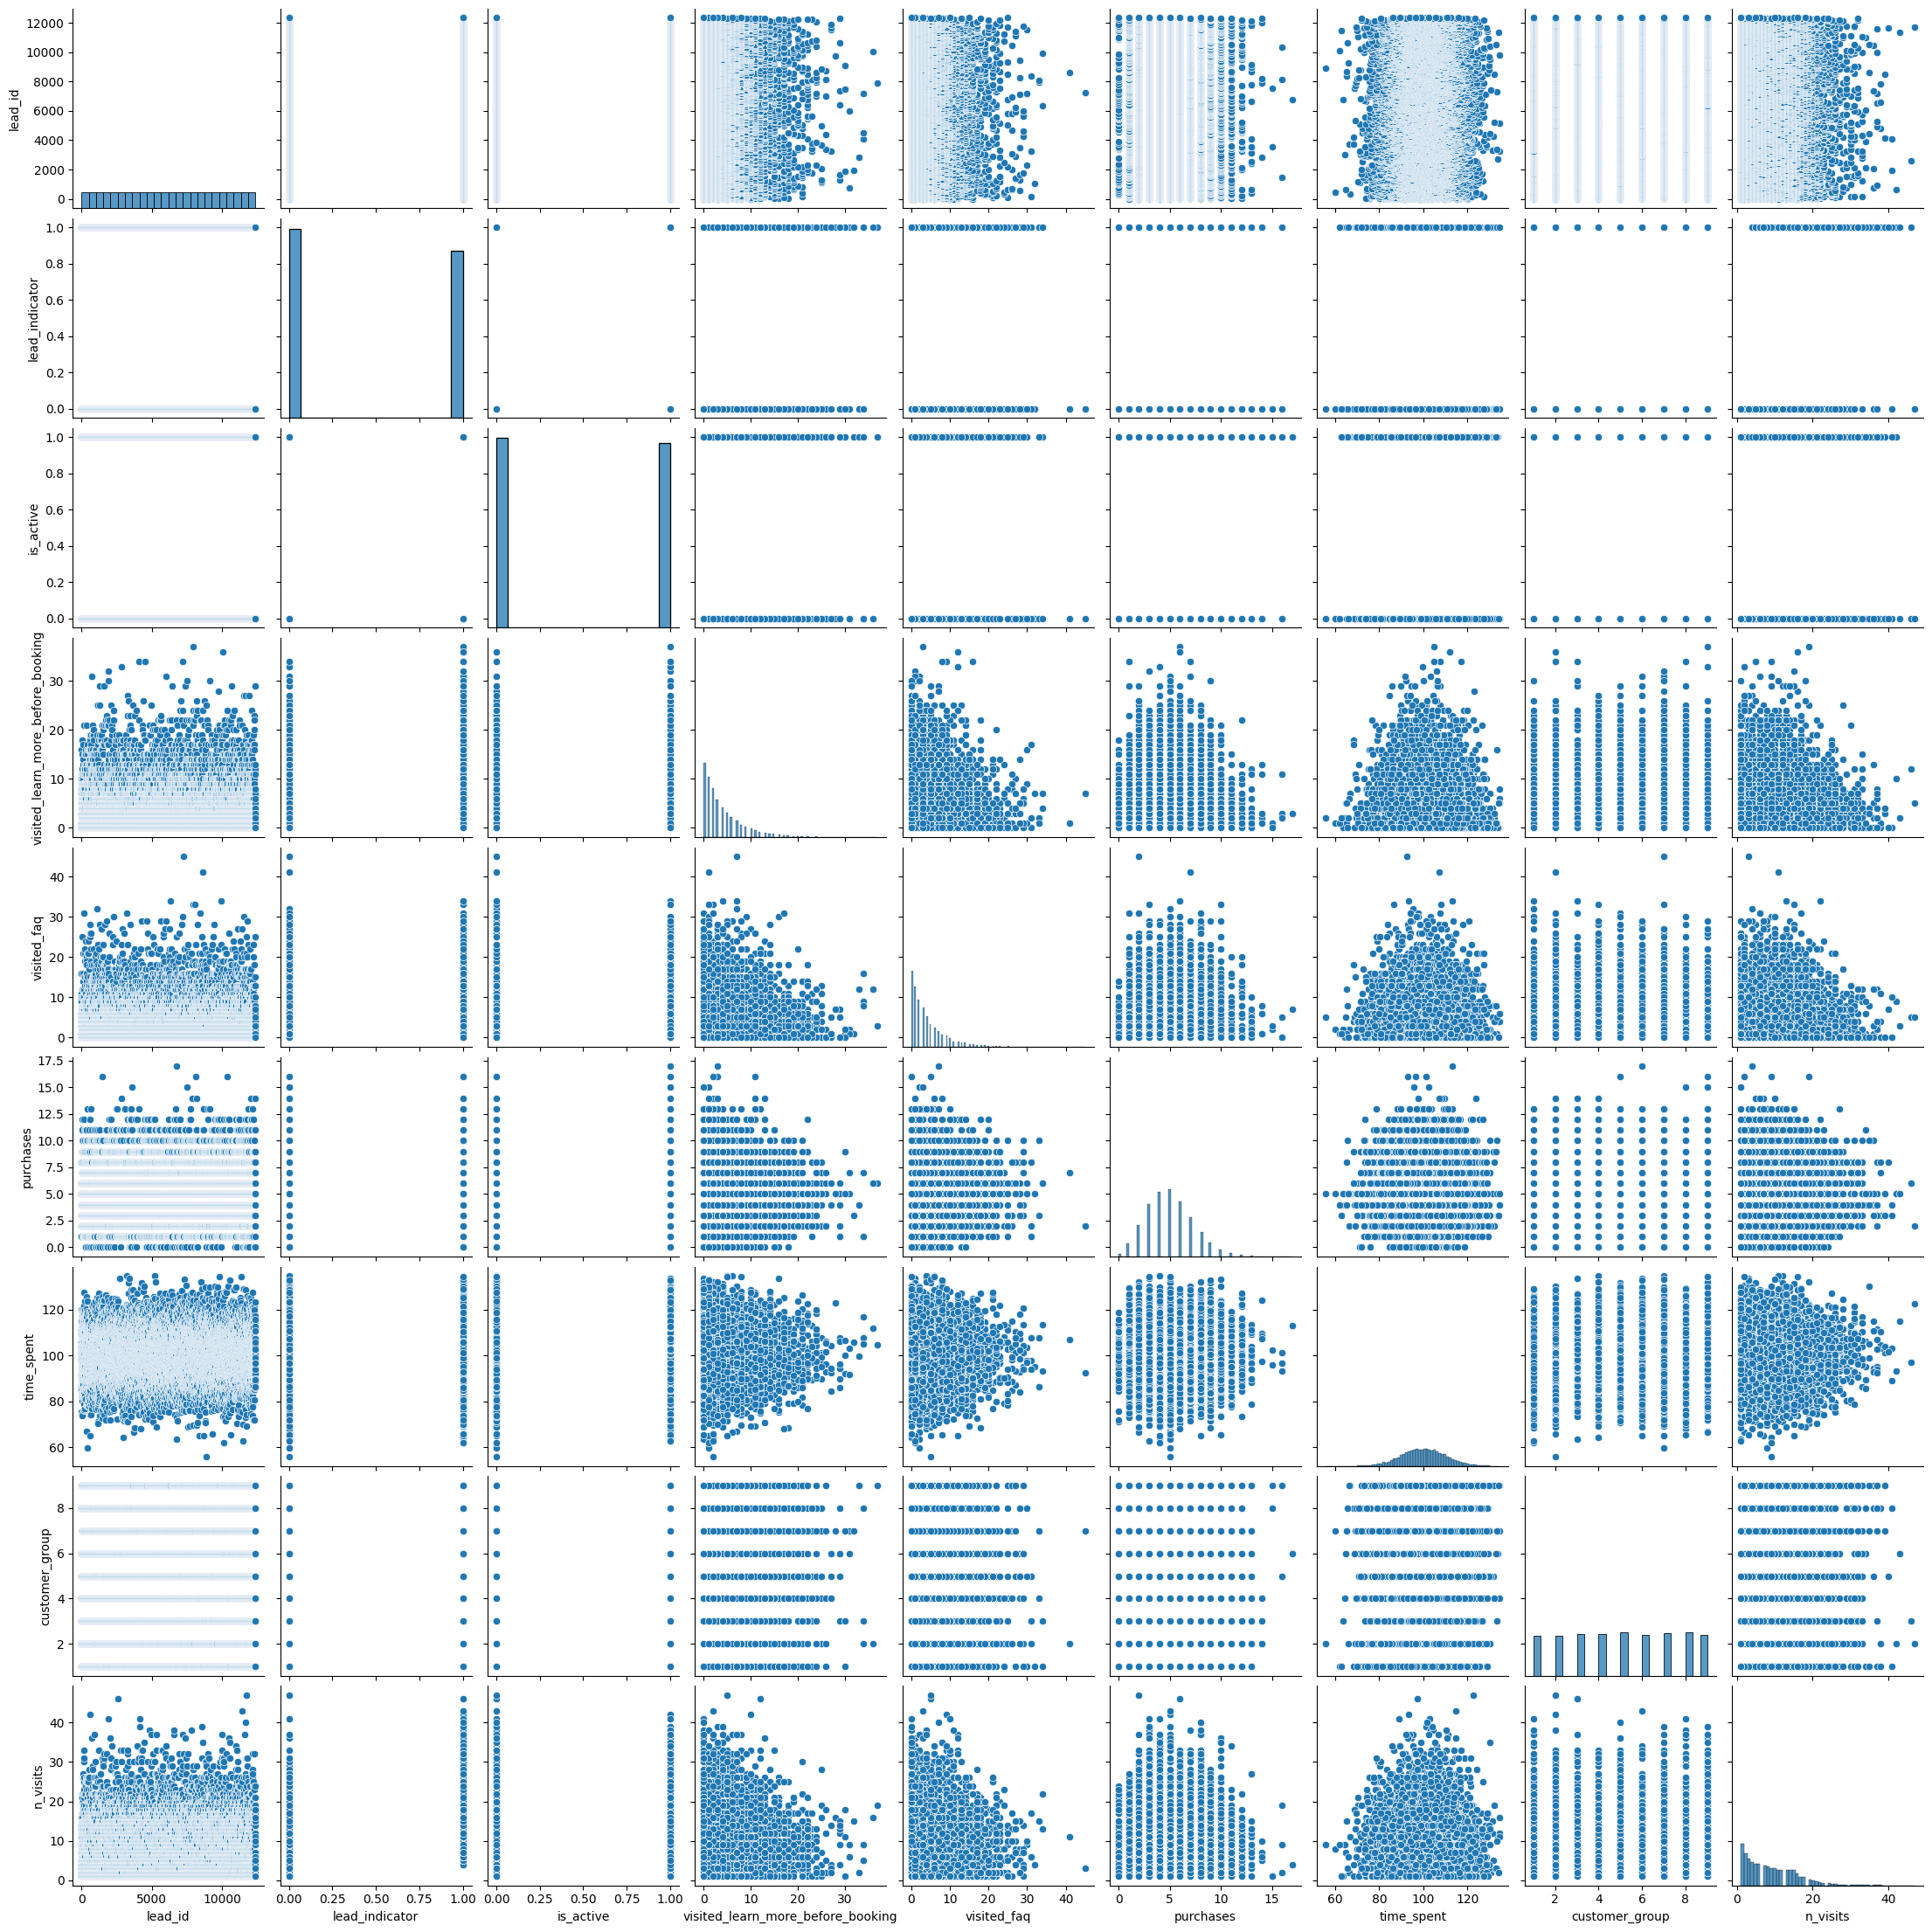

In [29]:
sns.pairplot(data.select_dtypes(include='number'))
plt.show()


# Feature selection

Not all columns are relevant for modelling

In [ ]:
data = data.drop(
    [
        "is_active", "marketing_consent", "first_booking", "existing_customer", "last_seen"
    ],
    axis=1
)

In [ ]:
#Removing columns that will be added back after the EDA
data = data.drop(
    ["domain", "country", "visited_learn_more_before_booking", "visited_faq"],
    axis=1
)

# Data cleaning
* Remove rows with empty target variable
* Remove rows with other invalid column data

In [ ]:
import numpy as np

data["lead_indicator"].replace("", np.nan, inplace=True)
data["lead_id"].replace("", np.nan, inplace=True)
data["customer_code"].replace("", np.nan, inplace=True)

data = data.dropna(axis=0, subset=["lead_indicator"])
data = data.dropna(axis=0, subset=["lead_id"])

data = data[data.source == "signup"]
result=data.lead_indicator.value_counts(normalize = True)

print("Target value counter")
for val, n in zip(result.index, result):
    print(val, ": ", n)
data

# Create categorical data columns

In [ ]:
vars = [
    "lead_id", "lead_indicator", "customer_group", "onboarding", "source", "customer_code"
]

for col in vars:
    data[col] = data[col].astype("object")
    print(f"Changed {col} to object type")

# Separate categorical and continuous columns

In [ ]:
cont_vars = data.loc[:, ((data.dtypes=="float64")|(data.dtypes=="int64"))]
cat_vars = data.loc[:, (data.dtypes=="object")]

print("\nContinuous columns: \n")
pprint(list(cont_vars.columns), indent=4)
print("\n Categorical columns: \n")
pprint(list(cat_vars.columns), indent=4)

# Outliers

Outliers are data points that significantly differ from the majority of observations in a dataset and can distort statistical analysis or model performance. To identify and remove outliers, one common method is to use the Z-score, which measures how many standard deviations a data point is from the mean. Data points with a Z-score greater than 2 (or sometimes 3) standard deviations away from the mean are typically considered outliers. By applying this threshold, we can filter out values that fall outside the normal range of the data, ensuring that the remaining dataset is more representative and less influenced by extreme values.

In [ ]:
cont_vars = cont_vars.apply(lambda x: x.clip(lower = (x.mean()-2*x.std()),
                                             upper = (x.mean()+2*x.std())))
outlier_summary = cont_vars.apply(describe_numeric_col).T
outlier_summary.to_csv('./artifacts/outlier_summary.csv')
outlier_summary

# Impute data

In real-world datasets, missing data is a common occurrence due to various factors such as human error, incomplete data collection processes, or system failures. These gaps in the data can hinder analysis and lead to biased results if not properly addressed. Since many analytical and machine learning algorithms require complete data, handling missing values is an essential step in the data preprocessing phase.

In the next code block, we will handle missing data by performing imputation. For numerical columns, we will replace missing values with the mean or median of the entire column, which provides a reasonable estimate based on the existing data. For categorical columns (object type), we will use the mode, or most frequent value, to fill in missing entries. This approach helps us maintain a complete dataset while ensuring that the imputed values align with the general distribution of each column.

In [ ]:
cat_missing_impute = cat_vars.mode(numeric_only=False, dropna=True)
cat_missing_impute.to_csv("./artifacts/cat_missing_impute.csv")
cat_missing_impute

In [ ]:
# Continuous variables missing values
cont_vars = cont_vars.apply(impute_missing_values)
cont_vars.apply(describe_numeric_col).T

In [ ]:
cat_vars.loc[cat_vars['customer_code'].isna(),'customer_code'] = 'None'
cat_vars = cat_vars.apply(impute_missing_values)
cat_vars.apply(lambda x: pd.Series([x.count(), x.isnull().sum()], index = ['Count', 'Missing'])).T
cat_vars

# Data standardisation

Standardization, or scaling, becomes necessary when continuous independent variables are measured on different scales, as this can lead to unequal contributions to the analysis. The objective is to rescale these variables so they have comparable ranges and/or variances, ensuring a more balanced influence in the model.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import joblib

scaler_path = "./artifacts/scaler.pkl"

scaler = MinMaxScaler()
scaler.fit(cont_vars)

joblib.dump(value=scaler, filename=scaler_path)
print("Saved scaler in artifacts")

cont_vars = pd.DataFrame(scaler.transform(cont_vars), columns=cont_vars.columns)
cont_vars

# Combine data

In [ ]:
cont_vars = cont_vars.reset_index(drop=True)
cat_vars = cat_vars.reset_index(drop=True)
data = pd.concat([cat_vars, cont_vars], axis=1)
print(f"Data cleansed and combined.\nRows: {len(data)}")
data

# Data drift artifact

In [ ]:
import json

data_columns = list(data.columns)
with open('./artifacts/columns_drift.json','w+') as f:           
    json.dump(data_columns,f)
    
data.to_csv('./artifacts/training_data.csv', index=False)

# Binning object columns

In [ ]:
data.columns

In [ ]:
data['bin_source'] = data['source']
values_list = ['li', 'organic','signup','fb']
data.loc[~data['source'].isin(values_list),'bin_source'] = 'Others'
mapping = {'li' : 'socials', 
           'fb' : 'socials', 
           'organic': 'group1', 
           'signup': 'group1'
           }

data['bin_source'] = data['source'].map(mapping)

# Save gold medallion dataset

In [ ]:
#spark.sql(f"drop table if exists train_gold")


In [ ]:
# data_gold = spark.createDataFrame(data)
# data_gold.write.saveAsTable('train_gold')
# dbutils.notebook.exit(('training_golden_data',most_recent_date))

data.to_csv('./artifacts/train_data_gold.csv', index=False)

# MODEL TRAINING

Training the model uses a training dataset for training an ML algorithm. It has sample output data and the matching input data that affects the output.

In [ ]:
import datetime

# Constants used:
current_date = datetime.datetime.now().strftime("%Y_%B_%d")
data_gold_path = "./artifacts/train_data_gold.csv"
data_version = "00000"
experiment_name = current_date

# Create paths

Maybe the artifacts path has not been created during data cleaning

In [ ]:
import os
import shutil

os.makedirs("artifacts", exist_ok=True)
os.makedirs("mlruns", exist_ok=True)
os.makedirs("mlruns/.trash", exist_ok=True)

In [ ]:
import mlflow

mlflow.set_experiment(experiment_name)

# Helper functions

* *create_dummies*: Create one-hot encoding columns in the data.

In [ ]:
def create_dummy_cols(df, col):
    df_dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
    new_df = pd.concat([df, df_dummies], axis=1)
    new_df = new_df.drop(col, axis=1)
    return new_df

# Load training data
We use the training data we cleaned earlier

In [ ]:
data = pd.read_csv(data_gold_path)
print(f"Training data length: {len(data)}")
data.head(5)

# Data type split

In [ ]:
data = data.drop(["lead_id", "customer_code", "date_part"], axis=1)

cat_cols = ["customer_group", "onboarding", "bin_source", "source"]
cat_vars = data[cat_cols]

other_vars = data.drop(cat_cols, axis=1)

# Dummy variable for categorical vars

1. Create one-hot encoded cols for cat vars
2. Change to floats

In [ ]:
import pandas as pd

for col in cat_vars:
    cat_vars[col] = cat_vars[col].astype("category")
    cat_vars = create_dummy_cols(cat_vars, col)

data = pd.concat([other_vars, cat_vars], axis=1)

for col in data:
    data[col] = data[col].astype("float64")
    print(f"Changed column {col} to float")

# Splitting data

In [ ]:
y = data["lead_indicator"]
X = data.drop(["lead_indicator"], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.15, stratify=y
)
y_train

# Model training

This stage involves training the ML algorithm by providing it with datasets, where the learning process takes place. Consistent training can significantly enhance the model's prediction accuracy. It's essential to initialize the model's weights randomly so the algorithm can effectively learn to adjust them.

# XGBoost

In [ ]:
from xgboost import XGBRFClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import randint

model = XGBRFClassifier(random_state=42)
params = {
    "learning_rate": uniform(1e-2, 3e-1),
    "min_split_loss": uniform(0, 10),
    "max_depth": randint(3, 10),
    "subsample": uniform(0, 1),
    "objective": ["reg:squarederror", "binary:logistic", "reg:logistic"],
    "eval_metric": ["aucpr", "error"]
}

model_grid = RandomizedSearchCV(model, param_distributions=params, n_jobs=-1, verbose=3, n_iter=10, cv=10)

model_grid.fit(X_train, y_train)

# Model test accuracy

In [ ]:
from sklearn.metrics import accuracy_score

best_model_xgboost_params = model_grid.best_params_
print("Best xgboost params")
pprint(best_model_xgboost_params)

y_pred_train = model_grid.predict(X_train)
y_pred_test = model_grid.predict(X_test)
print("Accuracy train", accuracy_score(y_pred_train, y_train ))
print("Accuracy test", accuracy_score(y_pred_test, y_test))


# XGBoost performance overview
* Confusion matrix
* Classification report

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Test actual/predicted\n")
print(pd.crosstab(y_test, y_pred_test, rownames=['Actual'], colnames=['Predicted'], margins=True),'\n')
print("Classification report\n")
print(classification_report(y_test, y_pred_test),'\n')

conf_matrix = confusion_matrix(y_train, y_pred_train)
print("Train actual/predicted\n")
print(pd.crosstab(y_train, y_pred_train, rownames=['Actual'], colnames=['Predicted'], margins=True),'\n')
print("Classification report\n")
print(classification_report(y_train, y_pred_train),'\n')

# Save best XGBoost model

In [ ]:
xgboost_model = model_grid.best_estimator_
xgboost_model_path = "./artifacts/lead_model_xgboost.json"
xgboost_model.save_model(xgboost_model_path)

model_results = {
    xgboost_model_path: classification_report(y_train, y_pred_train, output_dict=True)
}

# SKLearn logistic regression

In [ ]:
import mlflow.pyfunc

from sklearn.linear_model import LogisticRegression
import os
from sklearn.metrics import cohen_kappa_score, f1_score
import matplotlib.pyplot as plt
import joblib

class lr_wrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model
    
    def predict(self, context, model_input):
        return self.model.predict_proba(model_input)[:, 1]


mlflow.sklearn.autolog(log_input_examples=True, log_models=False)
experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

with mlflow.start_run(experiment_id=experiment_id) as run:
    model = LogisticRegression()
    lr_model_path = "./artifacts/lead_model_lr.pkl"

    params = {
              'solver': ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
              'penalty':  ["none", "l1", "l2", "elasticnet"],
              'C' : [100, 10, 1.0, 0.1, 0.01]
    }
    model_grid = RandomizedSearchCV(model, param_distributions= params, verbose=3, n_iter=10, cv=3)
    model_grid.fit(X_train, y_train)

    best_model = model_grid.best_estimator_

    y_pred_train = model_grid.predict(X_train)
    y_pred_test = model_grid.predict(X_test)


    # log artifacts
    mlflow.log_metric('f1_score', f1_score(y_test, y_pred_test))
    mlflow.log_artifacts("artifacts", artifact_path="model")
    mlflow.log_param("data_version", "00000")
    
    # store model for model interpretability
    joblib.dump(value=model, filename=lr_model_path)
        
    # Custom python model for predicting probability 
    mlflow.pyfunc.log_model('model', python_model=lr_wrapper(model))


model_classification_report = classification_report(y_test, y_pred_test, output_dict=True)

best_model_lr_params = model_grid.best_params_

print("Best lr params")
pprint(best_model_lr_params)

print("Accuracy train:", accuracy_score(y_pred_train, y_train ))
print("Accuracy test:", accuracy_score(y_pred_test, y_test))

conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Test actual/predicted\n")
print(pd.crosstab(y_test, y_pred_test, rownames=['Actual'], colnames=['Predicted'], margins=True),'\n')
print("Classification report\n")
print(classification_report(y_test, y_pred_test),'\n')

conf_matrix = confusion_matrix(y_train, y_pred_train)
print("Train actual/predicted\n")
print(pd.crosstab(y_train, y_pred_train, rownames=['Actual'], colnames=['Predicted'], margins=True),'\n')
print("Classification report\n")
print(classification_report(y_train, y_pred_train),'\n')

model_results[lr_model_path] = model_classification_report
print(model_classification_report["weighted avg"]["f1-score"])


# Save columns and model results

In [ ]:
column_list_path = './artifacts/columns_list.json'
with open(column_list_path, 'w+') as columns_file:
    columns = {'column_names': list(X_train.columns)}
    pprint(columns)
    json.dump(columns, columns_file)

print('Saved column list to ', column_list_path)

model_results_path = "./artifacts/model_results.json"
with open(model_results_path, 'w+') as results_file:
    json.dump(model_results, results_file)

# MODEL SELECTION

Model selection involves choosing the most suitable statistical model from a set of candidates. In straightforward cases, this process uses an existing dataset. When candidate models offer comparable predictive or explanatory power, the simplest model is generally the preferred choice.

In [ ]:
# Constants used:
current_date = datetime.datetime.now().strftime("%Y_%B_%d")
artifact_path = "model"
model_name = "lead_model"
experiment_name = current_date

# Helper functions

In [ ]:
import time
from mlflow.tracking.client import MlflowClient
from mlflow.entities.model_registry.model_version_status import ModelVersionStatus
from mlflow.tracking.client import MlflowClient

def wait_until_ready(model_name, model_version):
    client = MlflowClient()
    for _ in range(10):
        model_version_details = client.get_model_version(
          name=model_name,
          version=model_version,
        )
        status = ModelVersionStatus.from_string(model_version_details.status)
        print(f"Model status: {ModelVersionStatus.to_string(status)}")
        if status == ModelVersionStatus.READY:
            break
        time.sleep(1)


# Getting experiment model results

In [ ]:
experiment_ids = [mlflow.get_experiment_by_name(experiment_name).experiment_id]
experiment_ids

In [ ]:
experiment_best = mlflow.search_runs(
    experiment_ids=experiment_ids,
    order_by=["metrics.f1_score DESC"],
    max_results=1
).iloc[0]
experiment_best

In [ ]:
import json

with open("./artifacts/model_results.json", "r") as f:
    model_results = json.load(f)
results_df = pd.DataFrame({model: val["weighted avg"] for model, val in model_results.items()}).T
results_df

In [ ]:
best_model = results_df.sort_values("f1-score", ascending=False).iloc[0].name
print(f"Best model: {best_model}")

# Get production model

In [ ]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
prod_model = [model for model in client.search_model_versions(f"name='{model_name}'") if dict(model)['current_stage']=='Production']
prod_model_exists = len(prod_model)>0

if prod_model_exists:
    prod_model_version = dict(prod_model[0])['version']
    prod_model_run_id = dict(prod_model[0])['run_id']
    
    print('Production model name: ', model_name)
    print('Production model version:', prod_model_version)
    print('Production model run id:', prod_model_run_id)
    
else:
    print('No model in production')


# Compare prod and best trained model

In [ ]:
train_model_score = experiment_best["metrics.f1_score"]
model_details = {}
model_status = {}
run_id = None

if prod_model_exists:
    data, details = mlflow.get_run(prod_model_run_id)
    prod_model_score = data[1]["metrics.f1_score"]

    model_status["current"] = train_model_score
    model_status["prod"] = prod_model_score

    if train_model_score>prod_model_score:
        print("Registering new model")
        run_id = experiment_best["run_id"]
else:
    print("No model in production")
    run_id = experiment_best["run_id"]

print(f"Registered model: {run_id}")

# Register best model

In [ ]:
if run_id is not None:
    print(f'Best model found: {run_id}')

    model_uri = "runs:/{run_id}/{artifact_path}".format(
        run_id=run_id,
        artifact_path=artifact_path
    )
    model_details = mlflow.register_model(model_uri=model_uri, name=model_name)
    wait_until_ready(model_details.name, model_details.version)
    model_details = dict(model_details)
    print(model_details)

# DEPLOY

A model version can be assigned to one or more stages. MLflow provides predefined stages for common use cases: None, Staging, Production, and Archived. With the necessary permissions, you can transition a model version between stages or request a transition to a different stage.

In [ ]:
model_version = 1

# Transition to staging

In [ ]:
from mlflow.tracking import MlflowClient

client = MlflowClient()


def wait_for_deployment(model_name, model_version, stage='Staging'):
    status = False
    while not status:
        model_version_details = dict(
            client.get_model_version(name=model_name,version=model_version)
            )
        if model_version_details['current_stage'] == stage:
            print(f'Transition completed to {stage}')
            status = True
            break
        else:
            time.sleep(2)
    return status

model_version_details = dict(client.get_model_version(name=model_name,version=model_version))
model_status = True
if model_version_details['current_stage'] != 'Staging':
    client.transition_model_version_stage(
        name=model_name,
        version=model_version,stage="Staging", 
        archive_existing_versions=True
    )
    model_status = wait_for_deployment(model_name, model_version, 'Staging')
else:
    print('Model already in staging')